In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
from stl import mesh
import matplotlib.pyplot as plt

In [2]:
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(fr'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [3]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]


In [4]:
a = 3.4
lambdas = np.array([7,2])/0.8

In [5]:
folder_path = rf"H:\phd stuff\tidy3d\structures\LSU H5\20250124"
project_name = "02_14_2025 Florescu LSU H5 Far Field Transmission"
postprocess_results = []
runtime_ps = 25e-12
min_steps_per_lambda = 20
cuts = [1]
for direction in ["z"]: 
    for f,filename in enumerate(os.listdir(folder_path)):
     for cut in cuts:
        if not (Path(filename).suffix==".h5" or Path(filename).suffix==".stl"):
            continue 

           
        if os.path.isfile(os.path.join(folder_path, filename)):
            file=os.path.join(folder_path, filename)
            structure_1 = AM.loadAndRunStructure(key = tidy3dAPI, file_path=file
                                            ,direction=direction, lambda_range=lambdas,
                                            box_size=14.3,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                                           scaling=1,shuoff_condtion=1e-20, verbose=True, 
                                           monitors=["flux"], 
                                           freqs=400, 
                                           cut_condition=cut, source="planewave", absorbers=120, use_permittivity=False,sim_name=rf"{Path(filename).stem}_size_{cut}"
                                           )
            
        
        file_desc = rf"H:\phd stuff\tidy3d\data\{project_name}_perm_{structure_1.permittivity_value}\z_incidence\{structure_1.sim_name}.txt"
        # if os.path.exists(file_desc):
        #     print("Exist!")
        # else:
        #    print("Creating...")
        #    structure_1.run_sim(run_free=False,load=False,add_ref=True,folder_description=rf"{project_name}_perm_{structure_1.permittivity_value}",monitor=True)

        # del structure_1

            
        # structure_1.plot_sim_layout()


Configured successfully.


<Figure size 1280x960 with 0 Axes>

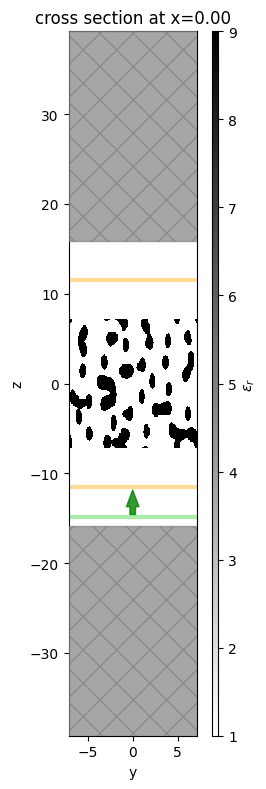

<Figure size 1600x1200 with 0 Axes>

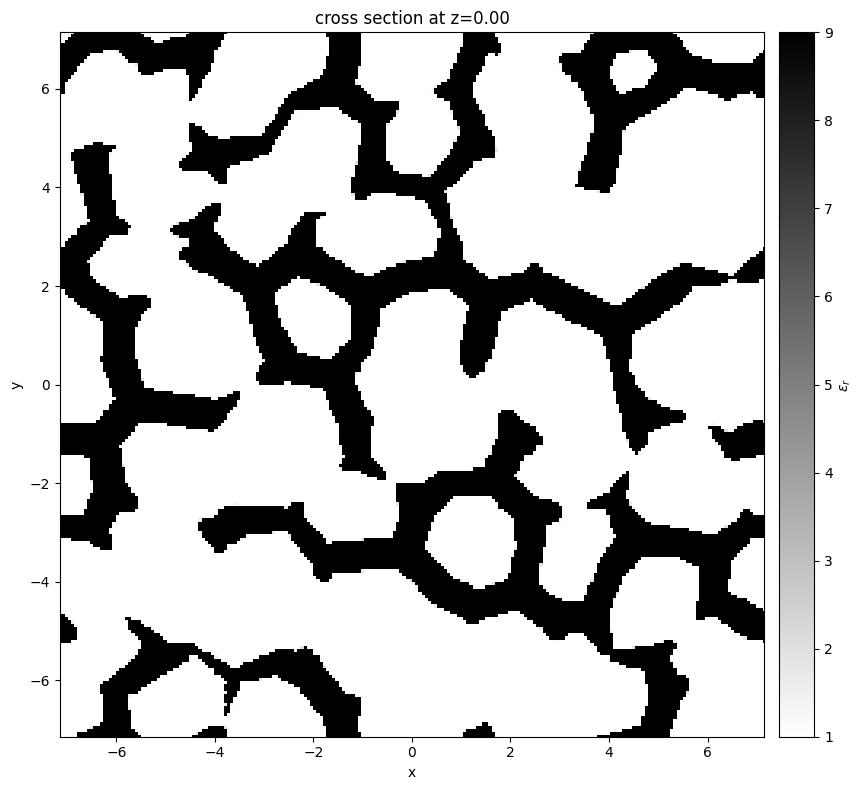

<Figure size 640x480 with 0 Axes>

In [6]:
structure_1.plot_sim_layout()

In [7]:
sim = structure_1.sim

In [8]:
#defining apertures 
# Define materials
air = td.Medium(permittivity=1)
pec = td.PECMedium()
# PEC plate thickness
thick = 1
width = 5
height = 5

# create the PEC plate
plate = td.Structure(
    geometry=td.Box(size=[td.inf, td.inf,thick], center=sim.monitors[1].center), medium=pec
)

# create the aperture in the plate
aperture = td.Structure(
    geometry=td.Box(size=[width, height,1.5 * thick], center=sim.monitors[1].center), medium=air
)

# make sure to append the aperture to the plate so that it overrides that region of the plate
geometry = structure_1.createSimObjects()["structures"]#+[plate,aperture]

In [9]:
# radial distance away from the origin at which to project fields
r_proj =  5e5

# theta and phi angles at which to observe fields - part of the half-space to the right
# theta_proj = np.linspace(np.pi / 10, np.pi - np.pi / 10, 100)
# phi_proj = np.linspace(np.pi / 10, np.pi - np.pi / 10, 100)
theta_proj = np.linspace(0, np.pi/2, 250)
phi_proj = np.linspace(0,2*np.pi, 250)

monitor_far = td.FieldProjectionAngleMonitor(
    center=sim.monitors[0].center,  # the monitor's center defined the local origin - the projection distance
    # and angles will all be measured with respect to this local origin
    size=[td.inf, td.inf,0],
    # the size and center of any far field monitor should indicate where the *near* fields are recorded
    freqs=structure_1.monitor_freqs,
    name="far_field",
    window_size= (0.25,0.25),
    normal_dir="+",
    phi=list(phi_proj),
    theta=list(theta_proj),
    proj_distance=r_proj,
    far_field_approx=True,  # we leave this to its default value of 'True' because we are interested in fields sufficiently
    # far away that geometric far field approximations can be invoked to speed up the calculation
)

In [10]:
sim = sim.copy(update={"structures":geometry, "monitors":[monitor_far]})


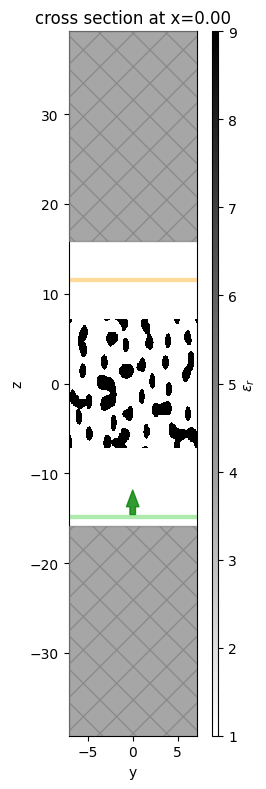

In [11]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
freqs_plot = (structure_1.freq_range[0], structure_1.freq_range[1])
sim.plot_eps(x=0, freq=freqs_plot[0], ax=ax)
plt.show()

In [12]:
run = True
if run:
        

        sim_data_0 = web.run(
            sim.copy(update={"structures":[]}), task_name="20250217_far_field_test_complete_angles_0", verbose=False
            )
        
        sim_data = web.run(
            sim, task_name="0250217_far_field_test_complete_angles", verbose=False
            )
        
else:
        sim_data_0 = web.load("fdve-7a440b9d-c313-4336-bfe9-b19cbcd6d055", verbose = False
            )
        
        sim_data = web.load("fdve-4f1c1788-59ff-4724-8522-568099dcc6b5", verbose=False
            
            )
    
      

17:49:56 W. Europe Standard Time WARNING: Simulation final field decay value of 
                                 6.15e-15 is greater than the simulation shutoff
                                 threshold of 1e-20. Consider running the       
                                 simulation again with a larger 'run_time'      
                                 duration for more accurate results.            

18:53:15 W. Europe Standard Time WARNING: Simulation final field decay value of 
                                 2.65e-06 is greater than the simulation shutoff
                                 threshold of 1e-20. Consider running the       
                                 simulation again with a larger 'run_time'      
                                 duration for more accurate results.            

In [79]:
projected_field_data_0 = sim_data_0[monitor_far.name]
projected_field_data = sim_data[monitor_far.name]


In [80]:
indices = np.where(np.bool_(theta_proj/np.pi >0.15) & np.bool_(theta_proj/np.pi <0.35))
indices

(array([ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174], dtype=int64),)

In [81]:
theta_proj[0:95]/np.pi

array([0.        , 0.00200803, 0.00401606, 0.0060241 , 0.00803213,
       0.01004016, 0.01204819, 0.01405622, 0.01606426, 0.01807229,
       0.02008032, 0.02208835, 0.02409639, 0.02610442, 0.02811245,
       0.03012048, 0.03212851, 0.03413655, 0.03614458, 0.03815261,
       0.04016064, 0.04216867, 0.04417671, 0.04618474, 0.04819277,
       0.0502008 , 0.05220884, 0.05421687, 0.0562249 , 0.05823293,
       0.06024096, 0.062249  , 0.06425703, 0.06626506, 0.06827309,
       0.07028112, 0.07228916, 0.07429719, 0.07630522, 0.07831325,
       0.08032129, 0.08232932, 0.08433735, 0.08634538, 0.08835341,
       0.09036145, 0.09236948, 0.09437751, 0.09638554, 0.09839357,
       0.10040161, 0.10240964, 0.10441767, 0.1064257 , 0.10843373,
       0.11044177, 0.1124498 , 0.11445783, 0.11646586, 0.1184739 ,
       0.12048193, 0.12248996, 0.12449799, 0.12650602, 0.12851406,
       0.13052209, 0.13253012, 0.13453815, 0.13654618, 0.13855422,
       0.14056225, 0.14257028, 0.14457831, 0.14658635, 0.14859

In [82]:
np.shape(projected_field_data_0.power) #(r,theta,phi,f)

(1, 250, 250, 400)

In [93]:
r,theta,phi = r_proj,theta_proj[0:95],phi_proj
# Calculate the differential surface area element in spherical coordinates
dA_1= (r ** 2) * np.sin(theta_proj) * np.diff(theta)[0] * np.diff(phi)[0]

# Compute total power by summing over theta and phi
transmission_0 = ((projected_field_data_0.power.squeeze().values)* dA_1[:,np.newaxis,np.newaxis]).sum(axis=(0,1))

In [94]:
dA_2= (r ** 2) * np.sin(theta) * np.diff(theta)[0] * np.diff(phi)[0]


In [95]:
transmission_low_lambda = ((projected_field_data.power.squeeze().values)[:95,:,np.where(structure_1.monitor_lambdas*0.8<=5.5)[0]]* dA_2[:,np.newaxis,np.newaxis]).sum(axis=(0,1))
transmission_high_lambda = ((projected_field_data.power.squeeze().values)[:,:,np.where(structure_1.monitor_lambdas*0.8>5.5)[0]]* dA_1[:,np.newaxis,np.newaxis]).sum(axis=(0,1))

transmission = np.concatenate((transmission_high_lambda,transmission_low_lambda),axis=0)

In [96]:
transmission_normalized = transmission/transmission_0

In [97]:
np.shape(transmission_normalized)

(400,)

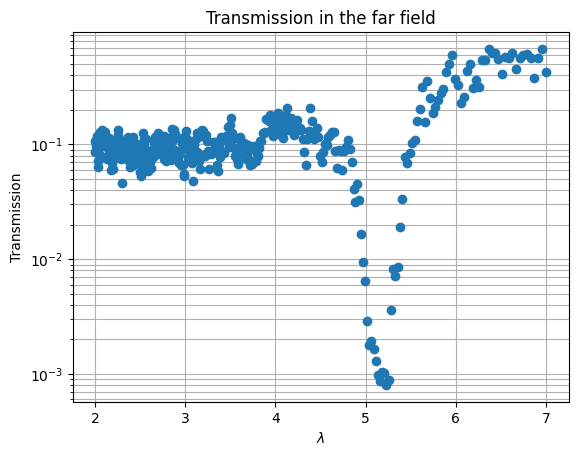

In [98]:
plt.plot(structure_1.monitor_lambdas*0.8,transmission_normalized,"o")
plt.yscale("log")
plt.ylabel("Transmission")
plt.xlabel(rf"$\lambda$")
# plt.ylim(1e-1,1)
plt.title("Transmission in the far field")
plt.grid(True, which="both")
plt.show()

In [99]:
data = {
                        'transmission_normalized':transmission_normalized,
                        'lambdas':structure_1.monitor_lambdas*0.8,
                  }
AM.create_hdf5_from_dict(data,"farfield 0-90.h5")